# 数据准备

Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_001.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_002.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_003.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_004.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_005.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_006.jpg
Now patchifying image: D:\Projects\VsCode\Python\img

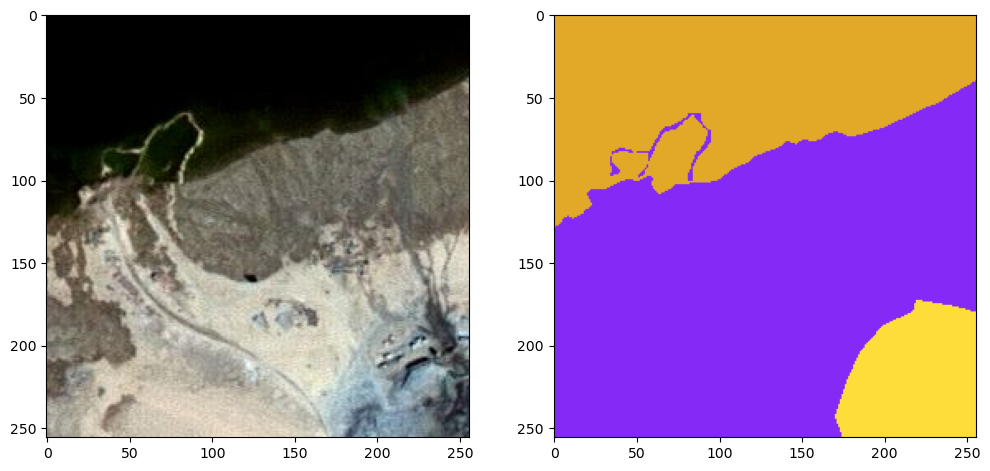

60
labels.shape =  (1305, 256, 256)
image_dataset.shape =  (1305, 256, 256, 3)
[0 1 2 3 4 5]


In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ['SM_FRAMEWORK'] = 'tf.keras'

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

root_directory = 'D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset'

patch_size = 256

# Read images from repsective 'images' subdirectory
# As all images are of ddifferent size we have 2 options, either resize or crop
# But, some images are too large and some small. Resizing will change the size of real objects.
# Therefore, we will crop them to a nearest size divisible by 256 and then 
# divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                #处理每个patch
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler\
                            .fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1]))\
                            .reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  
                
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset) # 所有images目录下所有图片的patch, 一共1305个patches, 每个都是256x256
mask_dataset =  np.array(mask_dataset)  # 所有images目录下所有mask的patch
print("len(image_dataset) = ", len(image_dataset))
print("len(mask_dataset) = ", len(mask_dataset))

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))  # 随机的image_number
plt.figure(figsize=(12, 6))
plt.subplot(121)
print("image_number =", image_number)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16): 
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

# 根据mask_dataset的RGB值，将其转换为256x256，且取值范围从[0,5]的二维label矩阵
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
print("labels.shape = ", labels.shape) # labels.shape= (1305, 256, 256)
print("image_dataset.shape = ", image_dataset.shape) # image_dataset.shape =  (1305, 256, 256, 3)
print(np.unique(labels)) # [0 1 2 3 4 5]




"""
# 将[0,5]的二维label矩阵转为6个二维且取值为0或1的矩阵。
labels = np.expand_dims(labels, axis=3) # 增加维度

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages, 目的为了防止在转换数据的过程中，出现某些问题
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0]) # 疑问：labels中的元素取值为0-5，那么图像应该是接近黑色。
plt.show()


############################################################################


n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes) # labels_cat.shape = (1305, 256, 256, 6)，元素值0和1
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size = 0.20, random_state = 42)


In [2]:
print(X_train[0: 10][:, :, :].shape)

(10, 256, 256, 3)


In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=6,                      # model output channels (number of classes in your dataset)
)

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 误差函数和优化器

In [4]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move model to device
model.to(device)

n_epochs = 10
batch_size = 10

for epoch in range(n_epochs):
    model.train()
    latest_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i : i+batch_size]    # numpy array shape (N, H, W, C)
        batch_y = y_train[i : i+batch_size]    # numpy array shape (N, H, W)

        # convert to torch tensors with correct shapes/dtypes:
        # inputs -> (N, C, H, W), float32
        inputs = torch.tensor(batch_X, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        # targets -> (N, H, W), long (required by CrossEntropyLoss)
        targets = torch.tensor(batch_y, dtype=torch.long).to(device) # targets.shape =[10, 256, 256]
        optimizer.zero_grad()
        outputs = model(inputs)  # outputs shape: (N, num_classes, H, W) , outputs.shape= [10, 6, 256, 256]
        loss = loss_fn(outputs, targets) # 疑问：为什么outputs和targets的shape不一样不会报错？
        loss.backward()
        optimizer.step()

        latest_loss = loss.item()

    print(f'Finished epoch {epoch}, latest loss {latest_loss}')

Finished epoch 0, latest loss 0.370416522026062
Finished epoch 1, latest loss 0.3329389691352844
Finished epoch 2, latest loss 0.2960495352745056
Finished epoch 3, latest loss 0.28187891840934753
Finished epoch 4, latest loss 0.23382936418056488
Finished epoch 5, latest loss 0.22446979582309723
Finished epoch 6, latest loss 0.2548348307609558
Finished epoch 7, latest loss 0.20507429540157318
Finished epoch 8, latest loss 0.18294784426689148
Finished epoch 9, latest loss 0.19774651527404785


In [ ]:
# 保存模型
torch.save(model, 'D:\Projects\VsCode\Python\img_processing_system\classification\cnn\models\my_228_training_aerial_imagery_model.pth')

(256, 256, 3)
torch.Size([1, 6, 256, 256])
[-5.860038  -5.8426337 -5.8350697 ...  5.036361   5.051911   5.0585446]


TypeError: Invalid shape (256, 256, 6) for image data

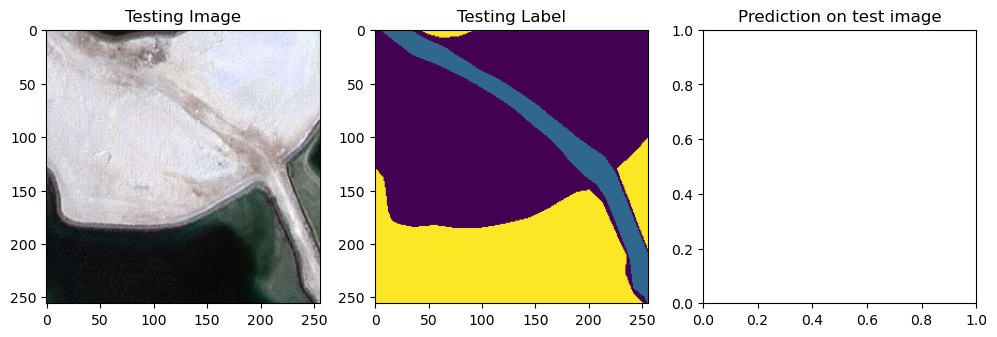

In [ ]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
# 如何把test_img交给模型来预测？
# 答：给test_img增加一个维度，然后调换维度的顺序
print(test_img.shape)
test_img_imput = np.expand_dims(test_img, axis=3) # 增加维度
predicted_img = model.predict(torch.tensor(test_img_imput, dtype=torch.float32).permute(3,2,0,1).to(device))
print(predicted_img.shape)
predicted_img = predicted_img.permute(2,3,1,0).cpu().numpy()
predicted_img = np.squeeze(predicted_img)
print(np.unique(predicted_img))# FIXME predicted_img中的元素有问题
ground_truth = y_test[test_img_number]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()